# Cyber Bullying Prediction using Natural Language Processing and Machine Learning

Author: Zak Davlin


### Intial Imports and File Read in

In [1]:
#Import needed modules
import pandas as pd
import numpy as np
import csv
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from spacy.lang.en import English
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
#Read in CSV file
CB=pd.read_csv("cyberbullying_tweets[1].csv", sep=",")
#First 5 rows
CB.head(5)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Data Clean up

In [3]:
#How much data do we have?
print(len(CB), "rows in the dataset.")
CB.cyberbullying_type.value_counts()

47692 rows in the dataset.


religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [4]:
CB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
#Add a column to clean text
CB['Clean_Text'] = CB.loc[:,'tweet_text']
CB.head(5)

,tweet_text,cyberbullying_type,Clean_Text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"In other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is #aussietv so white? #MKR #theblock #ImA...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,@XochitlSuckkks a classy whore? Or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,@RudhoeEnglish This is an ISIS account pretend...


In [6]:
#Clean Text in the clean text column
#Remove duplicates if any
CB.drop_duplicates(subset=['tweet_text'])
#Replace popular abbreviations
CB["Clean_Text"] = CB["Clean_Text"].str.replace(" r "," are ")
CB["Clean_Text"] = CB["Clean_Text"].str.replace(" n "," in ")
CB["Clean_Text"] = CB["Clean_Text"].str.replace(" ur "," you're ")
CB["Clean_Text"] = CB["Clean_Text"].str.replace(" u "," you ")
CB["Clean_Text"] = CB["Clean_Text"].str.replace("#","")
#Create a function to remove all @name as they do not pertain to the statements and are random user names
def Tweet_username_removal(x):
    x=x.split()
    x_new=[x for x in x if not x.startswith("@")]
    return ' '.join(x_new)
CB["Clean_Text"] = CB["Clean_Text"].apply(Tweet_username_removal)
nlp=English()
stop_words = nlp.Defaults.stop_words
def stopword_removal(x):
    x=x.split()
    x_new=[x for x in x if x not in stop_words]
    return ' '.join(x_new)
CB["Clean_Text"] = CB["Clean_Text"].apply(stopword_removal)
print(CB.info())
CB.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
 2   Clean_Text          47692 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB
None


,tweet_text,cyberbullying_type,Clean_Text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"In words katandandre, food crapilicious! mkr"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why aussietv white? MKR theblock ImACelebrityA...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore? Or red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"meh. :P thanks heads up, concerned angry dude ..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,This ISIS account pretending Kurdish account. ...


Looks like we have no duplicates!

### Feature Engineering 

In [7]:
#Use text blob to add sentiment analysis 
from textblob import TextBlob
polarity_Subjectivity_scores=[]
#add blank columns to CB data frame
for text in CB['Clean_Text']:
    analysis = TextBlob(text)
    polarity_Subjectivity_scores.append((analysis.sentiment.polarity, analysis.sentiment.subjectivity))
SentimentDF=pd.DataFrame(polarity_Subjectivity_scores, columns=['Polarity','Subjectivity'])

In [8]:
CBFD=pd.merge(CB, SentimentDF,left_index=True, right_index=True)
CBFD.head(5)

,tweet_text,cyberbullying_type,Clean_Text,Polarity,Subjectivity
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"In words katandandre, food crapilicious! mkr",0.00,0.000000
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why aussietv white? MKR theblock ImACelebrityA...,0.00,0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore? Or red velvet cupcakes?,0.05,0.450000
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"meh. :P thanks heads up, concerned angry dude ...",0.15,0.733333
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,This ISIS account pretending Kurdish account. ...,0.00,0.000000


In [9]:
CBFD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_text          47692 non-null  object 
 1   cyberbullying_type  47692 non-null  object 
 2   Clean_Text          47692 non-null  object 
 3   Polarity            47692 non-null  float64
 4   Subjectivity        47692 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.8+ MB


### Exploratory Data Analysis

In [10]:
CBFD.describe()

,Polarity,Subjectivity
count,47692.000000,47692.000000
mean,-0.039786,0.457177
std,0.340110,0.303707
min,-1.000000,0.000000
25%,-0.218750,0.200000
50%,0.000000,0.519395
75%,0.148182,0.666667
max,1.000000,1.000000


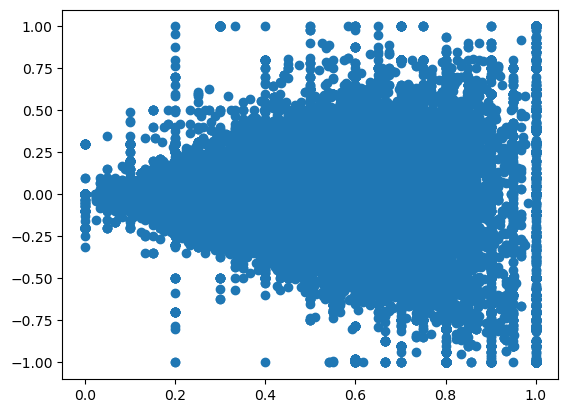

In [11]:
plt.scatter(CBFD['Subjectivity'],CBFD['Polarity'])

(array([  737.,  2356.,  3342.,  6367.,  6331., 19422.,  4829.,  3006.,
          678.,   624.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

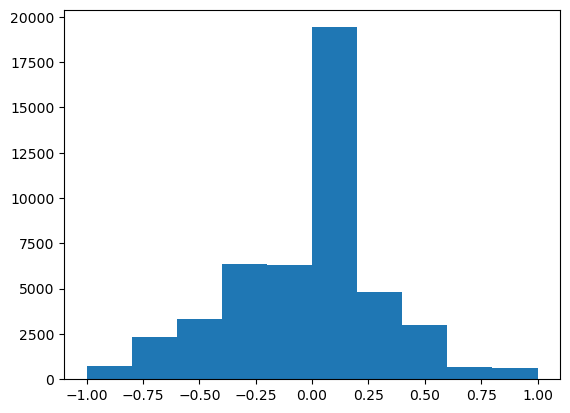

In [12]:
plt.hist(CBFD['Polarity'])

(array([10262.,  1289.,  2658.,  3071.,  4394., 10385.,  5502.,  3522.,
         2778.,  3831.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

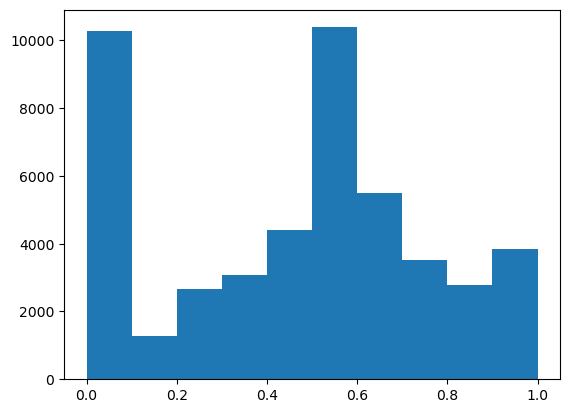

In [13]:
plt.hist(CBFD['Subjectivity'])

(array([  612.,  2099.,  2993.,  5916.,  5833., 14851.,  4164.,  2439.,
          465.,   375.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

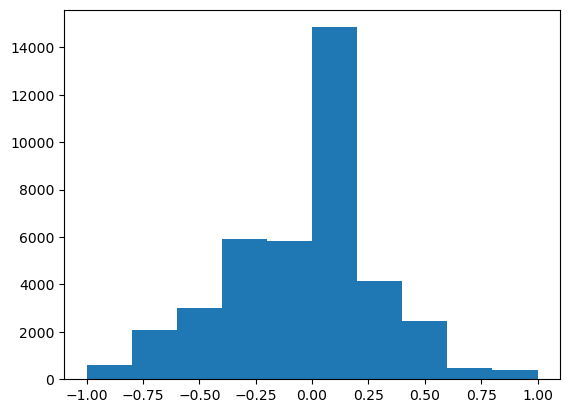

In [14]:
CBFDFilter = CBFD[CBFD['cyberbullying_type']!='not_cyberbullying']
plt.hist(CBFDFilter['Polarity'])

(array([  612.,  2099.,  2993.,  5916.,  5833., 14851.,  4164.,  2439.,
          465.,   375.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

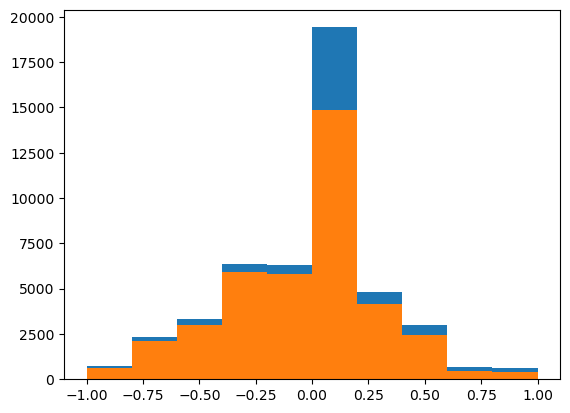

In [15]:
plt.hist(CBFD['Polarity'])
plt.hist(CBFDFilter['Polarity'])

(array([6701., 1064., 2267., 2829., 4001., 9536., 4880., 3248., 2395.,
        2826.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

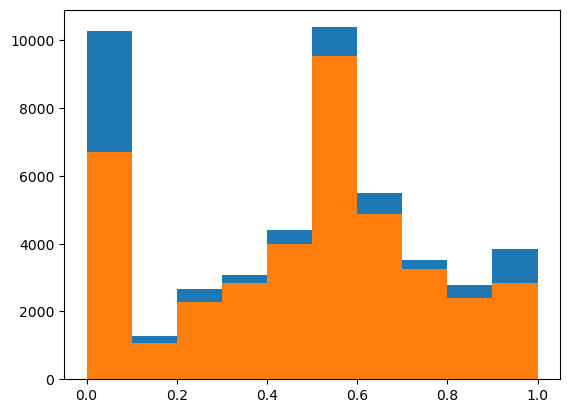

In [16]:
plt.hist(CBFD['Subjectivity'])
plt.hist(CBFDFilter['Subjectivity'])

In [17]:
CBFDFilter.describe()

,Polarity,Subjectivity
count,39747.000000,39747.000000
mean,-0.055208,0.479274
std,0.338711,0.284278
min,-1.000000,0.000000
25%,-0.250000,0.300000
50%,0.000000,0.540000
75%,0.146905,0.667929
max,1.000000,1.000000


### Model Building

In [18]:
#Naive Bayes basic model
#Create a bag of words so Naive Bayes model can fit data

text_vector = Pipeline([
('vect', CountVectorizer()),
('clf' , MultinomialNB()),])


X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

#construct model
text_vector.fit(X_train, y_train)
y_pred = text_vector.predict(X_test)

Train size:  38153 Test size:  9539


In [19]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

Accuracy: 0.7602474053884055
F1 score: 0.742071146519077
                     precision    recall  f1-score   support

                age       0.73      0.99      0.84      1554
          ethnicity       0.85      0.92      0.88      1626
             gender       0.83      0.80      0.82      1622
  not_cyberbullying       0.65      0.40      0.49      1597
other_cyberbullying       0.61      0.48      0.54      1566
           religion       0.81      0.98      0.88      1574

           accuracy                           0.76      9539
          macro avg       0.75      0.76      0.74      9539
       weighted avg       0.75      0.76      0.74      9539



In [20]:
confusion_matrix(y_test,y_pred)

array([[1535,    6,    2,    3,    1,    7],
       [  44, 1492,   10,    4,   22,   54],
       [  30,   39, 1302,  109,  101,   41],
       [ 248,   82,  111,  634,  359,  163],
       [ 231,  126,  136,  214,  752,  107],
       [   5,   10,    7,   12,    3, 1537]], dtype=int64)

In [21]:
#Apply term frequency-inverse document frequency transformation. This will give rare words higher values.
text_Tfidf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf' , MultinomialNB()),
])

X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)

print('Train size: ', len(X_train), 'Test size: ', len(X_test))
#construct model with tfidf
text_Tfidf.fit(X_train, y_train)
y_pred = text_Tfidf.predict(X_test)

Train size:  38153 Test size:  9539


In [22]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test,y_pred)

Accuracy: 0.7469336408428556
F1 score: 0.7253759550836955
                     precision    recall  f1-score   support

                age       0.70      0.98      0.82      1554
          ethnicity       0.83      0.90      0.87      1626
             gender       0.80      0.82      0.81      1622
  not_cyberbullying       0.66      0.37      0.47      1597
other_cyberbullying       0.62      0.44      0.52      1566
           religion       0.78      0.97      0.87      1574

           accuracy                           0.75      9539
          macro avg       0.73      0.75      0.73      9539
       weighted avg       0.73      0.75      0.73      9539



array([[1521,    8,    4,    2,    4,   15],
       [  64, 1462,   15,    5,   17,   63],
       [  46,   47, 1329,   89,   69,   42],
       [ 267,   90,  127,  590,  335,  188],
       [ 253,  136,  167,  201,  694,  115],
       [  14,   10,   11,    7,    3, 1529]], dtype=int64)

In [23]:
#support vector Machine
text_clf = Pipeline([
('vect', CountVectorizer()),
('clf', SGDClassifier()),
])
X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

text_clf.fit(X_train, y_train)
y_pred2=text_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred2))
print('F1 score:', f1_score(y_test, y_pred2, average="macro"))
print(classification_report(y_test, y_pred2))
confusion_matrix(y_test,y_pred2)

Train size:  38153 Test size:  9539
Accuracy: 0.8248244050739071
F1 score: 0.8260288582151799
                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1554
          ethnicity       0.98      0.95      0.97      1626
             gender       0.89      0.84      0.87      1622
  not_cyberbullying       0.61      0.52      0.56      1597
other_cyberbullying       0.57      0.71      0.63      1566
           religion       0.96      0.95      0.96      1574

           accuracy                           0.82      9539
          macro avg       0.83      0.83      0.83      9539
       weighted avg       0.83      0.82      0.83      9539



array([[1512,    2,    4,   18,   15,    3],
       [   6, 1549,    6,   16,   42,    7],
       [   1,    7, 1362,  112,  135,    5],
       [  17,    7,   63,  828,  632,   50],
       [   5,   11,   87,  345, 1114,    4],
       [   1,    4,    3,   30,   33, 1503]], dtype=int64)

In [24]:
#Decision Tree Classifier
DTC = Pipeline([
('vect', CountVectorizer()),
('clf',DecisionTreeClassifier()),
])
X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

DTC.fit(X_train, y_train)
y_pred3=DTC.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred3))
print('F1 score:', f1_score(y_test, y_pred3, average="macro"))
print(classification_report(y_test, y_pred3))
confusion_matrix(y_test,y_pred3)

Train size:  38153 Test size:  9539
Accuracy: 0.7924310724394591
F1 score: 0.7940724245875889
                     precision    recall  f1-score   support

                age       0.98      0.97      0.97      1554
          ethnicity       0.97      0.95      0.96      1626
             gender       0.85      0.83      0.84      1622
  not_cyberbullying       0.52      0.51      0.51      1597
other_cyberbullying       0.52      0.56      0.54      1566
           religion       0.94      0.94      0.94      1574

           accuracy                           0.79      9539
          macro avg       0.80      0.79      0.79      9539
       weighted avg       0.80      0.79      0.79      9539



array([[1504,    3,    4,   21,   18,    4],
       [   2, 1548,    5,   18,   43,   10],
       [   2,    3, 1344,  121,  143,    9],
       [  20,   10,   99,  810,  601,   57],
       [   5,   20,  122,  534,  875,   10],
       [   1,    5,   12,   60,   18, 1478]], dtype=int64)

In [25]:
#Random Forest Classifier
RFC = Pipeline([
('vect', CountVectorizer()),
('clf',RandomForestClassifier(n_estimators=100, max_depth=5)),
])
X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

RFC.fit(X_train, y_train)
y_pred3=RFC.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred3))
print('F1 score:', f1_score(y_test, y_pred3, average="macro"))
print(classification_report(y_test, y_pred3))
confusion_matrix(y_test,y_pred3)

Train size:  38153 Test size:  9539
Accuracy: 0.7367648600482231
F1 score: 0.7011313409702701
                     precision    recall  f1-score   support

                age       0.79      0.98      0.88      1554
          ethnicity       0.90      0.94      0.92      1626
             gender       0.88      0.70      0.78      1622
  not_cyberbullying       0.45      0.76      0.56      1597
other_cyberbullying       0.68      0.09      0.17      1566
           religion       0.86      0.95      0.90      1574

           accuracy                           0.74      9539
          macro avg       0.76      0.74      0.70      9539
       weighted avg       0.76      0.74      0.70      9539



array([[1520,    2,    2,   18,    1,   11],
       [  17, 1523,    6,   32,    9,   39],
       [  67,   36, 1142,  329,   23,   25],
       [ 173,   46,   54, 1207,   36,   81],
       [ 133,   78,   88, 1038,  148,   81],
       [   5,    9,    9,   63,    0, 1488]], dtype=int64)

In [26]:
#NeuralNet
NN = Pipeline([
('vect', CountVectorizer()),
('clf',MLPClassifier(activation='relu', solver='adam',alpha=0.0001, batch_size=1000, learning_rate_init=0.001,max_iter=100, verbose=1),)
])
X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

NN.fit(X_train, y_train)
y_pred3=NN.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred3))
print('F1 score:', f1_score(y_test, y_pred3, average="macro"))
confusion_matrix(y_test,y_pred3)

Train size:  38153 Test size:  9539
Iteration 1, loss = 1.32898797
Iteration 2, loss = 0.66052285
Iteration 3, loss = 0.42983177
Iteration 4, loss = 0.32478337
Iteration 5, loss = 0.26348255
Iteration 6, loss = 0.22275130
Iteration 7, loss = 0.19399854
Iteration 8, loss = 0.17289842
Iteration 9, loss = 0.15672715
Iteration 10, loss = 0.14419790
Iteration 11, loss = 0.13423173
Iteration 12, loss = 0.12552617
Iteration 13, loss = 0.11916339
Iteration 14, loss = 0.11423683
Iteration 15, loss = 0.10928755
Iteration 16, loss = 0.10542243
Iteration 17, loss = 0.10147156
Iteration 18, loss = 0.09912751
Iteration 19, loss = 0.09613735
Iteration 20, loss = 0.09419759
Iteration 21, loss = 0.09152578
Iteration 22, loss = 0.08976247
Iteration 23, loss = 0.08800710
Iteration 24, loss = 0.08646013
Iteration 25, loss = 0.08496672
Iteration 26, loss = 0.08437072
Iteration 27, loss = 0.08292271
Iteration 28, loss = 0.08170557
Iteration 29, loss = 0.08060315
Iteration 30, loss = 0.07953552
Iteration 31,

C:\Users\zdavl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 score: 0.7755151125790517


array([[1461,    7,   15,   32,   35,    4],
       [  12, 1514,   10,   36,   44,   10],
       [   7,    9, 1302,  149,  148,    7],
       [  32,    9,  120,  789,  599,   48],
       [  10,   18,  133,  554,  839,   12],
       [   3,    7,   17,   54,   27, 1466]], dtype=int64)

In [27]:
#votingClassifier
pipeline1=Pipeline([
('vect', CountVectorizer()),
('SVM', SGDClassifier()),
('DTC', DecisionTreeClassifier()),
('NB', MultinomialNB())
])
voting_clf= VotingClassifier(estimators=[
('SVM', SGDClassifier()),
('DTC', DecisionTreeClassifier()),
('NB', MultinomialNB())
], voting='hard')

pipeline1.set_params(SVM=None)
pipeline1.set_params(DTC=None)
pipeline1.set_params(NB=None)
pipeline1.steps.append(['voting_clf', voting_clf])

pipeline1.fit(X_train, y_train)
y_pred4=pipeline1.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred4))
print('F1 score:', f1_score(y_test, y_pred4, average="macro"))
print(classification_report(y_test, y_pred4))
confusion_matrix(y_test,y_pred4)

Accuracy: 0.8150749554460636
F1 score: 0.8098632901326325
                     precision    recall  f1-score   support

                age       0.88      0.98      0.93      1554
          ethnicity       0.93      0.96      0.95      1626
             gender       0.87      0.85      0.86      1622
  not_cyberbullying       0.63      0.50      0.56      1597
other_cyberbullying       0.59      0.64      0.61      1566
           religion       0.95      0.96      0.96      1574

           accuracy                           0.82      9539
          macro avg       0.81      0.82      0.81      9539
       weighted avg       0.81      0.82      0.81      9539



array([[1527,    2,    2,   10,   10,    3],
       [  16, 1567,    2,    9,   24,    8],
       [  13,   17, 1374,  102,  111,    5],
       [  89,   29,   87,  793,  539,   60],
       [  82,   61,  116,  303,  998,    6],
       [   3,    7,    6,   35,    7, 1516]], dtype=int64)

Lets try only using the sentiment values that have been added

In [28]:
#Decision Tree Classifier polarity and subjectivity
X = CBFD[['Polarity','Subjectivity' ]]
y = CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)
y_pred5 = tree_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred5))
print('F1 score:', f1_score(y_test, y_pred5, average="macro"))
print(classification_report(y_test, y_pred5))
confusion_matrix(y_test,y_pred5)

Train size:  38153 Test size:  9539
Accuracy: 0.6735506866547856
F1 score: 0.6831249178955178
                     precision    recall  f1-score   support

                age       0.90      0.79      0.84      1554
          ethnicity       0.93      0.88      0.91      1626
             gender       0.89      0.62      0.73      1622
  not_cyberbullying       0.39      0.77      0.52      1597
other_cyberbullying       0.51      0.34      0.41      1566
           religion       0.78      0.62      0.69      1574

           accuracy                           0.67      9539
          macro avg       0.73      0.67      0.68      9539
       weighted avg       0.73      0.67      0.68      9539



array([[1235,   13,   12,  201,   56,   37],
       [  19, 1438,    8,  104,   34,   23],
       [  25,   23,  999,  406,  124,   45],
       [  44,   19,   38, 1232,  193,   71],
       [  25,   17,   37,  847,  539,  101],
       [  31,   31,   25,  393,  112,  982]], dtype=int64)

In [29]:
svc_model = SVC()
svc_model.fit(X,y)
y_pred5 = svc_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred5))
print('F1 score:', f1_score(y_test, y_pred5, average="macro"))
print(classification_report(y_test, y_pred5))
confusion_matrix(y_test,y_pred5)

Accuracy: 0.38505084390397315
F1 score: 0.3641720368613637
                     precision    recall  f1-score   support

                age       0.34      0.51      0.41      1554
          ethnicity       0.51      0.66      0.58      1626
             gender       0.39      0.23      0.29      1622
  not_cyberbullying       0.35      0.50      0.41      1597
other_cyberbullying       0.43      0.17      0.25      1566
           religion       0.30      0.22      0.25      1574

           accuracy                           0.39      9539
          macro avg       0.38      0.38      0.36      9539
       weighted avg       0.39      0.39      0.37      9539



array([[ 798,  245,  174,  156,   34,  147],
       [ 273, 1080,   46,   89,   24,  114],
       [ 483,  184,  368,  317,   90,  180],
       [ 217,  116,  151,  806,  150,  157],
       [ 207,  110,  117,  645,  274,  213],
       [ 356,  393,   97,  310,   71,  347]], dtype=int64)

Find a model to combine all data

In [30]:
#Create a pipeline to make arrays
Text_vect_A = Pipeline([
('vect', CountVectorizer()),
])

X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

#combine original data frame with array data frame
Text_vect_A.fit(X, y)
CBFDarrays=Text_vect_A.transform(X)
CBFDarrays1 = pd.DataFrame(CBFDarrays, columns=['array'])
CBFD1 = CBFD.drop(['tweet_text','Clean_Text'],axis=1)
CBFD_concat = pd.concat([CBFDarrays1, CBFD1], axis=1)
CBFD_concat.info()
CBFD_concat.head(5)
CBFD_concat.to_csv('TestData.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   array               47692 non-null  object 
 1   cyberbullying_type  47692 non-null  object 
 2   Polarity            47692 non-null  float64
 3   Subjectivity        47692 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.5+ MB


In [ ]:
drop column in data frame python

In [31]:
#test a tweet off the best model
Xnew=[""]
ynew=text_clf.predict(Xnew)
print(ynew)

['other_cyberbullying']


In [39]:
#support vector Machine
text_clfN = Pipeline([
('vect', CountVectorizer()),
('clf', SGDClassifier()),
])

CBFD.drop(CBFD[CBFD['cyberbullying_type']=='other_cyberbullying'].index,inplace=True)

X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

text_clfN.fit(X_train, y_train)
y_pred2=text_clfN.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred2))
print('F1 score:', f1_score(y_test, y_pred2, average="macro"))
print(classification_report(y_test, y_pred2))
confusion_matrix(y_test,y_pred2)

Train size:  31895 Test size:  7974
Accuracy: 0.9246300476548783
F1 score: 0.925953437509883
                   precision    recall  f1-score   support

              age       0.97      0.98      0.98      1527
        ethnicity       0.97      0.97      0.97      1577
           gender       0.93      0.84      0.89      1627
not_cyberbullying       0.80      0.89      0.84      1610
         religion       0.97      0.95      0.96      1633

         accuracy                           0.92      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.92      0.93      7974



array([[1503,    3,    2,   18,    1],
       [   4, 1524,   10,   35,    4],
       [   4,   14, 1374,  230,    5],
       [  31,   20,   88, 1425,   46],
       [   3,    3,    4,   76, 1547]], dtype=int64)

In [57]:
#test a tweet off the best model
Xnew=[""]
ynew=text_clfN.predict(Xnew)
print(ynew)

['not_cyberbullying']


In [58]:
#Decision Tree Classifier
DTC = Pipeline([
('vect', CountVectorizer()),
('clf',DecisionTreeClassifier()),
])
X=CBFD['Clean_Text']

y=CBFD['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101)
print('Train size: ', len(X_train), 'Test size: ', len(X_test))

DTC.fit(X_train, y_train)
y_pred3=DTC.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred3))
print('F1 score:', f1_score(y_test, y_pred3, average="macro"))
print(classification_report(y_test, y_pred3))
confusion_matrix(y_test,y_pred3)

Train size:  31895 Test size:  7974
Accuracy: 0.9079508402307499
F1 score: 0.908876526150476
                   precision    recall  f1-score   support

              age       0.97      0.98      0.97      1527
        ethnicity       0.98      0.97      0.97      1577
           gender       0.85      0.87      0.86      1627
not_cyberbullying       0.80      0.79      0.79      1610
         religion       0.96      0.94      0.95      1633

         accuracy                           0.91      7974
        macro avg       0.91      0.91      0.91      7974
     weighted avg       0.91      0.91      0.91      7974



array([[1494,    4,    2,   27,    0],
       [   8, 1527,    7,   30,    5],
       [   6,    9, 1408,  199,    5],
       [  36,   19,  225, 1270,   60],
       [   2,    6,   16,   68, 1541]], dtype=int64)